In [1]:
import sys
sys.path.append('..')
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os, json, pickle, tqdm
from scipy.stats import gaussian_kde
import seaborn as sns
from pathlib import Path

col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
col_frac   = [f'FR_{x}' for x in 'ABCDE']

# F-polymers dataset

In [147]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

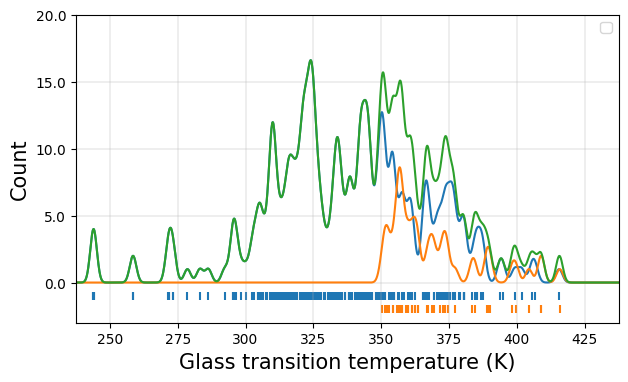

In [149]:
# TG histogram
cmap = plt.get_cmap('viridis')
#df = pd.read_csv('./data/fpolymers_230823.csv')
train_df = pd.read_csv('../data/fpolymers.tg.train.csv')
test_df = pd.read_csv('../data/fpolymers.tg.test.csv')
f, ax = plt.subplots(1,1,figsize=(7,4))
ax.grid(lw=0.3)
x = np.linspace(225, 475, 2000)
ax.set_xlim([237.5,437.5])
train_tgs = train_df.TG + 273.15
test_tgs = test_df.TG + 273.15
g1 = gaussian_kernel(train_tgs, 3)
g2 = gaussian_kernel(test_tgs, 3)
g3 = gaussian_kernel(np.hstack([train_tgs, test_tgs]), 3)
ax.plot(x, g1(x) )
ax.scatter(train_tgs, [-1]*len(train_tgs), marker='|')
ax.plot(x, g2(x) )
ax.scatter(test_tgs, [-2]*len(test_tgs), marker='|')
ax.plot(x, g3(x) )
#sns.histplot(train_df.TG + 273.15, bins=x, alpha=0.6, label=f'Train data ({len(train_df.TG)})', ax=ax, zorder=10)
#sns.histplot(test_df.TG + 273.15, bins=x, alpha=0.6, label=f'Test data ({len(test_df.TG)})', ax=ax, zorder=15)
#sns.histplot(np.hstack([train_df.TG, test_df.TG]) + 273.15, bins=x, alpha=1, label=f'Test data ({len(test_df.TG)})', ax=ax, zorder=5)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Glass transition temperature (K)', fontsize=15)
#ax.legend(loc='upper left', fontsize=12)
h, l = ax.get_legend_handles_labels()
ax.legend(h[1::2], l[1::2])
ax.set_yticks([-3.5, 0, 5, 10, 15, 20])
ax.set_ylim([-3, 20])
f.savefig('../../figs/tg_count_kde.pdf')

In [11]:
(train_df.TG < 380 - 273.15).sum(), (train_df.TG < 380 - 273.15).sum() / len(train_df)

(227, 0.926530612244898)

In [27]:
df[(df == 'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C').sum(1) != 0]

,ID,Name,CAS_A,CAS_B,CAS_C,CAS_D,CAS_E,SMILES_A,SMILES_B,SMILES_C,...,FR_A,FR_B,FR_C,FR_D,FR_E,ES,DC,TG,MW,TGA_0.01
59,FA-00180,0061_PF-IBNMA-CO-5,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,5.0,0.0,1.0,2.0,NaN,1.96,135.80,56513.0,141.05
60,FA-00182,0062_PF-IBNMA-CO-3,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,3.0,2.0,1.0,2.0,NaN,1.72,135.84,56450.0,151.48
61,FA-00183,0063_PF-IBNMA-CO-1,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,1.0,4.0,1.0,2.0,NaN,2.19,110.26,49009.0,115.81
215,FA-00355,157_IBNMA-442,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,NaN,4.0,4.0,NaN,2.0,NaN,1.84,100.50,62769.0,134.18


In [15]:
np.median(np.hstack([train_df.TG.values, test_df.TG.values])) + 273.15, np.mean(np.hstack([train_df.TG.values, test_df.TG.values])) + 273.15

(344.825, 342.4624489795918)

- molar mass

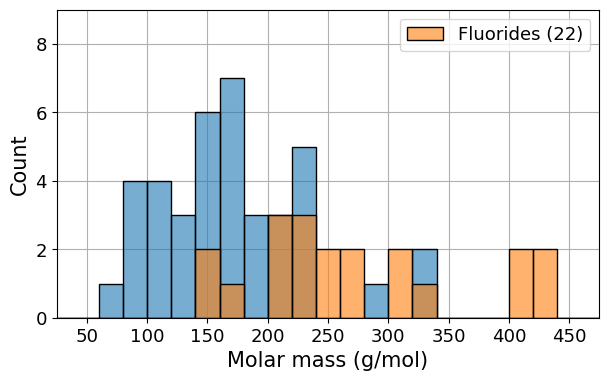

In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
smiles = np.unique(df[col_smiles].values.reshape(-1))
f_mask = np.array(['F' in s for s in smiles])
mol_wts = np.array([Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles])

f, ax = plt.subplots(1,1,figsize=(7,4))
x = np.linspace(0,600,31)
sns.histplot(mol_wts[~f_mask], ax=ax, bins=x, alpha=0.6, zorder=20, label=f'Non-fluorides ({np.sum(~f_mask)})')
sns.histplot(mol_wts[f_mask], ax=ax, bins=x, alpha=0.6, zorder=20, label=f'Fluorides ({np.sum(f_mask)})')
ax.grid()
ax.set_yticks([0,2,4,6,8])
ax.set_xlim([25,475])
ax.set_ylim([0,9])
h, l = ax.get_legend_handles_labels()
ax.legend(h[1::2], l[1::2])
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Molar mass (g/mol)', fontsize=15)

f.savefig(Path('./figs/mw_count.pdf').expanduser())

In [20]:
se = df.SMILES_E.values
for s in np.unique(se):
    print(s, np.sum(s == se))

CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 35
CC(=C)C(=O)OCCO 294
OCCOC(=O)C=C 7


22 39 61


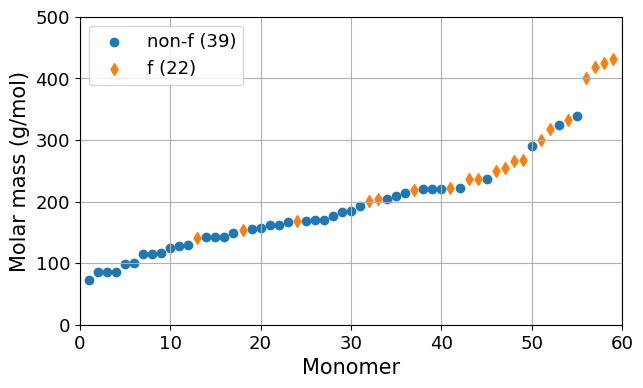

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors

df = pd.read_csv('./data/fpolymers_221123.csv')
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
smiles = np.unique(df[col_smiles].values.reshape(-1))
#smiles = np.unique(np.vstack([train_df[col_smiles].values, test_df[col_smiles].values]).reshape(-1))
#smiles = np.unique(df[col_smiles].values.reshape(-1))
f_mask = np.array(['F' in s for s in smiles])
mol_wts = np.array([Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles])

f, ax = plt.subplots(1,1,figsize=(7,4))
x = np.argsort(mol_wts)
_mol_wts = mol_wts[x]
f_mask = np.array(['F' in smiles[i] for i in x])
print(np.sum(f_mask), np.sum(~f_mask), len(smiles))
ax.scatter(np.where(~f_mask)[0]+1, _mol_wts[~f_mask], marker='o', label=f'non-f ({np.sum(~f_mask)})')
ax.scatter(np.where(f_mask)[0]+1, _mol_wts[f_mask], marker='d', label=f'f ({np.sum(f_mask)})')
ax.grid()
#ax.set_yticks([0,2,4,6,8])
#ax.set_xlim([25,475])
#ax.set_ylim([0,9])
h, l = ax.get_legend_handles_labels()
ax.legend(loc='upper left')
ax.set_xlabel('Monomer', fontsize=15)
ax.set_ylabel('Molar mass (g/mol)', fontsize=15)
ax.set_ylim([0,500])
ax.set_xlim([0,60])

f.savefig(Path('./figs/mw_order.pdf').expanduser())

- Number of monomers

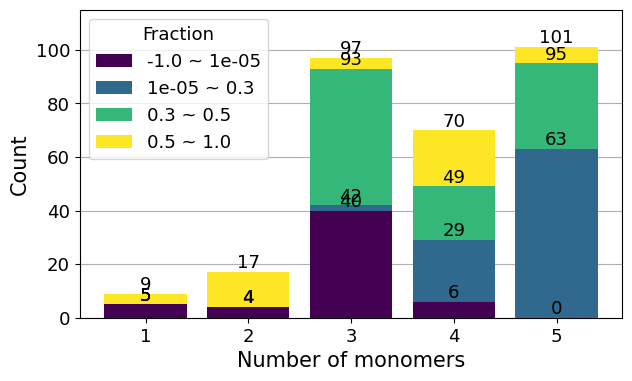

In [16]:
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
col_weights = [f'FR_{x}' for x in 'ABCDE']
train_df['isTrain'] = True
test_df['isTrain'] = False
df = pd.concat([train_df, test_df])
isFluo = []
fracFluo = []
numMono = []
isTrain = []
for id, row in df.iterrows():
    ws = row[col_weights].fillna(0).values
    m  = ws != 0
    ss = row[col_smiles].values[m]
    isFluo.append(np.sum(['F' in s for s in ss]))
    fracFluo.append(np.sum([w for s, w in zip(ss, ws[m]) if 'F' in s]) / np.sum(ws))
    numMono.append(np.sum(m))
    isTrain.append(row.isTrain)
isFluo   = np.array(isFluo)
fracFluo = np.array(fracFluo)
fracFluo[np.isnan(fracFluo)] = 0
numMono  = np.array(numMono)
isTrain  = np.array(isTrain)

ys = []
bins = np.array([-1,1e-5, 0.3, 0.5, 1])
for i in range(1,6):
    y, _ = np.histogram(fracFluo[numMono == i], bins=bins)
    ys.append(y)
labels = [f'{b1} ~ {b2}' for b1, b2 in zip(bins[:-1], bins[1:])]
x = np.array([1,2,3,4,5])
z = np.array([0,0,0,0,0])
f, ax = plt.subplots(1,1,figsize=(7,4))
for i, y in enumerate(np.array(ys).T):
    bars = ax.bar(x, y, bottom=z, color=plt.get_cmap('viridis')(i/(len(bins)-2)), label=labels[i], zorder=10)
    ax.bar_label(bars, zorder=15)
    z += y
ax.legend(loc='upper left',title='Fraction')
ax.set_xlabel('Number of monomers', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_ylim([0,115])
ax.grid(axis='y', zorder=0)
f.savefig(Path('./figs/monomer_count.pdf').expanduser())

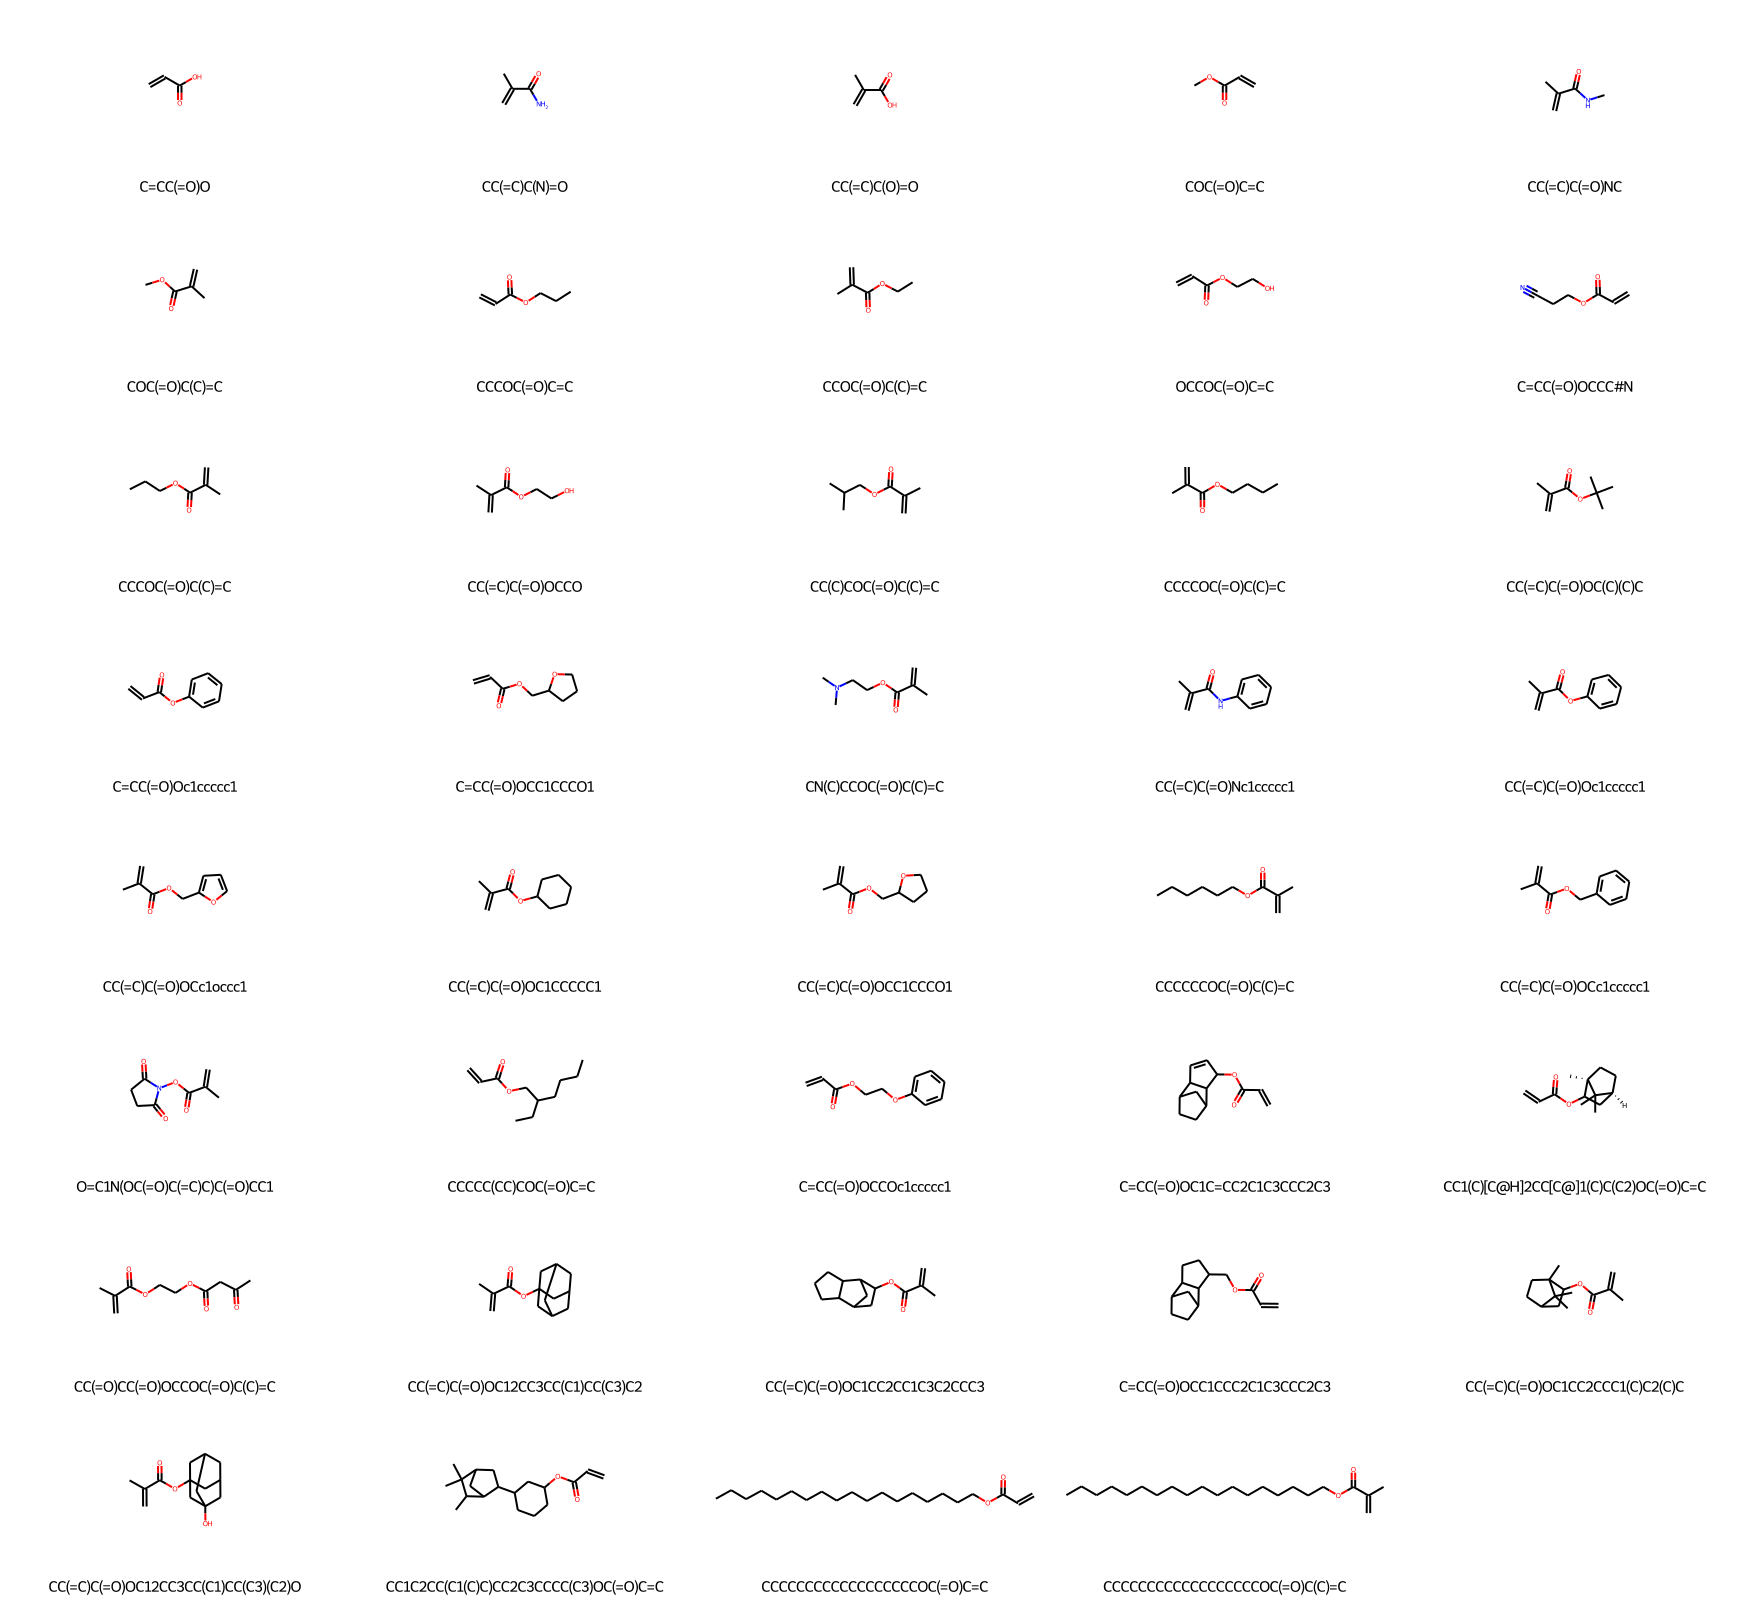

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

df = pd.concat([train_df, test_df])
smiles = np.unique(df[[f'SMILES_{x}' for x in 'ABCDE']].values)
smiles_f = sorted([s for s in smiles if 'F' in s], key=lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
smiles_c = sorted([s for s in smiles if 'F' not in s], key=lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
mol_f = [Chem.MolFromSmiles(s) for s in smiles_f]
mol_c = [Chem.MolFromSmiles(s) for s in smiles_c]
Draw.MolsToGridImage(mol_c, subImgSize=(350,200), molsPerRow=5, legends=smiles_c, useSVG=True)
#Draw.MolsToGridImage(mol_f, subImgSize=(350,200), molsPerRow=5, legends=smiles_f, useSVG=True)

# Comparison btw QM9 and F-polymer

In [75]:
df_qm9 = pd.read_csv('../data/qm9.csv')
df_fpoly = pd.concat([
    pd.read_csv('../data/fpolymers.tg.screen.csv'),
    pd.read_csv('../data/fpolymers.tg.train.csv'),
    pd.read_csv('../data/fpolymers.tg.test.csv'),
])

In [123]:
stats = {'H':[0, 0, 0, 0,],'C':[0, 0, 0, 0,],'N':[0, 0, 0, 0,],'O':[0, 0, 0, 0,],'F':[0, 0, 0, 0,]}
counts = [[], []]
f_bonds = [{}, {}]

for i, ss in enumerate([df_qm9.smiles, sorted(np.unique(df_fpoly[col_smiles].fillna('').values.reshape(-1)))[1:]]):
    for s in tqdm.tqdm(ss, total=len(ss)):
        m = Chem.AddHs(Chem.MolFromSmiles(s))
        hasF = False
        for ele, cnt in zip(*np.unique([a.GetSymbol() for a in m.GetAtoms()], return_counts=True)):
            if ele not in stats:
                stats[ele] = [0,0,0,0]
            stats[ele][i*2] += cnt
            stats[ele][i*2 + 1] += 1
            if ele == 'F': hasF = True
        counts[i].append(len(m.GetAtoms()))
        if hasF:
            for b in m.GetBonds():
                bond = tuple(sorted([b.GetBeginAtom().GetSymbol(), b.GetEndAtom().GetSymbol()]))
                if 'F' not in bond: continue
                if bond not in f_bonds[i].keys():
                    f_bonds[i][bond] = 0
                f_bonds[i][bond] += 1


100%|██████████| 61/61 [00:00<00:00, 10003.62it/s]


In [124]:
stats, f_bonds

({'H': [1230122, 133835, 726, 61],
  'C': [846556, 133882, 568, 61],
  'N': [139764, 82859, 6, 6],
  'O': [187997, 113938, 133, 61],
  'F': [3314, 2163, 174, 22]},
 [{('C', 'F'): 3314}, {('C', 'F'): 174}])

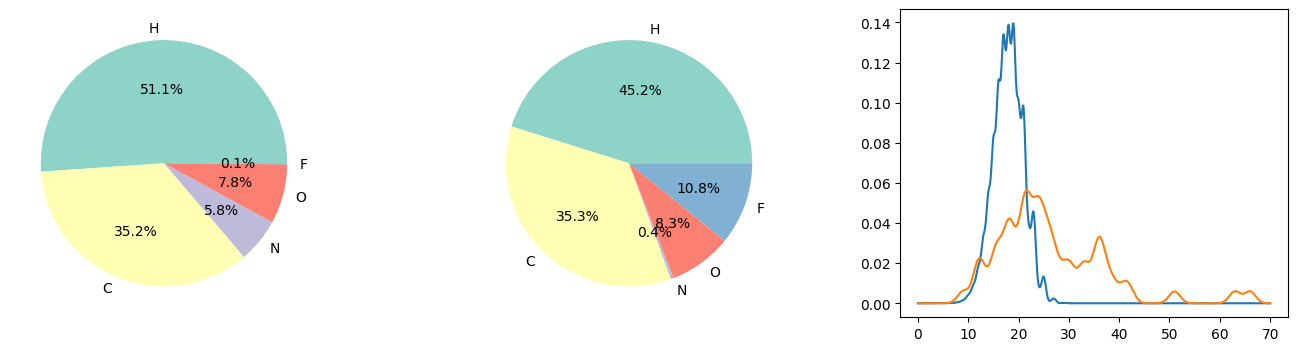

In [145]:
labels = [k for k in stats.keys()]
values = np.array([v for v in stats.values()]).T

f, axs = plt.subplots(1, 3, figsize=(17, 4))
for ax, value in zip(axs[:2], values[[0, 2]]):
    ax.pie(value, labels=labels, autopct='%.1f%%', colors=[mpl.cm.Set3(i) for i in range(5)])

g1 = gaussian_kde(counts[0], bw_method=0.15)
g2 = gaussian_kde(counts[1], bw_method=0.1)
x = np.linspace(0,70,1000)
axs[2].plot(x, g1(x))
axs[2].plot(x, g2(x))
f.savefig('../../figs/data.stats.pdf')

In [88]:
np.uniquecounts[0]

[5,
 4,
 3,
 4,
 3,
 4,
 8,
 6,
 7,
 6,
 7,
 6,
 11,
 9,
 9,
 9,
 7,
 10,
 9,
 8,
 14,
 12,
 6,
 5,
 4,
 6,
 5,
 6,
 10,
 10,
 9,
 8,
 8,
 7,
 10,
 9,
 8,
 8,
 14,
 12,
 12,
 10,
 12,
 10,
 11,
 10,
 12,
 10,
 12,
 10,
 9,
 9,
 8,
 17,
 15,
 9,
 8,
 8,
 8,
 9,
 9,
 8,
 13,
 12,
 11,
 11,
 10,
 13,
 11,
 12,
 11,
 13,
 12,
 12,
 11,
 12,
 11,
 10,
 10,
 10,
 15,
 13,
 17,
 15,
 15,
 15,
 13,
 13,
 10,
 11,
 10,
 9,
 10,
 9,
 15,
 13,
 13,
 13,
 11,
 15,
 13,
 14,
 13,
 11,
 13,
 11,
 9,
 8,
 7,
 9,
 8,
 9,
 8,
 8,
 9,
 8,
 9,
 11,
 13,
 12,
 13,
 12,
 11,
 11,
 10,
 11,
 10,
 13,
 12,
 11,
 11,
 11,
 17,
 15,
 15,
 15,
 13,
 13,
 11,
 10,
 9,
 10,
 9,
 8,
 11,
 10,
 9,
 10,
 15,
 13,
 14,
 13,
 13,
 12,
 11,
 13,
 10,
 11,
 15,
 13,
 11,
 13,
 11,
 11,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 6,
 7,
 6,
 5,
 11,
 13,
 15,
 13,
 12,
 11,
 5,
 10,
 9,
 10,
 9,
 8,
 13,
 12,
 11,
 11,
 12,
 11,
 10,
 10,
 11,
 10,
 10,
 13,
 12,
 12,
 11,
 12,
 11,
 11,
 10,
 11,
 10,
 9,
 13,
 12,
 12,
 11,
 

# make blacklist

In [12]:
from src.utils.dataset import QM9Dataset, FPolyDatasetV2, collate_fn

qd = QM9Dataset()
fd = FPolyDatasetV2()

qd.load('./data/cache_qm9.csv_n0x180fe1f_0x20afd.pkl')
fd.load('./data/cache_fpolymers_230823.tg.train.csv_v2n0xfff_0x380xf5.pkl')

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Setting new attribute : tag
  Setting new attribute : cache_fn
  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Setting new attribute : tag
  Setting new attribute : cache_fn
  Setting new attribute : unique_data


In [23]:
feat_q = collate_fn(qd)[0]
feat_f = collate_fn(fd)[0]

In [31]:
feat_q[0].keys()

dict_keys(['atom_feat', 'bond_feat', 'bond_idx', 'mol_feat', 'graph_idx', 'weight', 'data_idx'])

In [57]:
names = {}
for k in ['atom_feat', 'bond_feat','mol_feat']:
    f0 = feat_q[0][k].numpy().std(0) > 1e-2
    f1 = feat_f[0][k].numpy().std(0) > 1e-2
    f2 = feat_f[1][k].numpy().std(0) > 1e-2
    f3 = np.vstack([feat_f[0][k].numpy(), feat_f[1][k].numpy()]).std(0) > 1e-2
    print(np.sum(f0), np.sum(f1), np.sum(f2), np.sum(f3), np.sum(f0 & f1 & f2), np.sum(f0 & f3))
    print(np.array(getattr(qd, k+'_name'))[~(f0 & f3)])
    names[k] = np.array(getattr(qd, k+'_name'))[~(f0 & f3)].tolist()
with open('blacklist.json','w') as f:
    json.dump(names, f, indent=4)

21 23 21 23 20 21
['block' 'fusion_heat' 'metallic_radius' 'ele_config_d' 'ele_config_f']
5 5 5 5 5 5
[]
296 245 273 277 233 266
['NumRadicalElectrons' 'PEOE_VSA1' 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12'
 'PEOE_VSA13' 'PEOE_VSA14' 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5'
 'PEOE_VSA6' 'PEOE_VSA7' 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10'
 'SMR_VSA2' 'SMR_VSA3' 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7'
 'SMR_VSA8' 'SMR_VSA9' 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11'
 'SlogP_VSA12' 'SlogP_VSA2' 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VSA5'
 'SlogP_VSA6' 'SlogP_VSA7' 'SlogP_VSA8' 'SlogP_VSA9' 'TPSA' 'EState_VSA1'
 'EState_VSA10' 'EState_VSA11' 'EState_VSA2' 'EState_VSA3' 'EState_VSA4'
 'EState_VSA5' 'EState_VSA6' 'EState_VSA7' 'EState_VSA8' 'EState_VSA9'
 'VSA_EState1' 'VSA_EState10' 'VSA_EState2' 'VSA_EState3' 'VSA_EState4'
 'VSA_EState5' 'VSA_EState6' 'VSA_EState7' 'VSA_EState8' 'VSA_EState9'
 'fr_ArN' 'fr_Ar_COO' 'fr_Ar_N' 'fr_Ar_NH' 'fr_Ar_OH' 'fr_C_S' 'fr_HOCCN'
 'fr_Imine' 'fr_N

# Visualization of molecule (skeletal)

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
df1 = pd.read_csv('./data/fpolymers_230823.tg.train.csv')
df2 = pd.read_csv('./data/fpolymers_230823.tg.test.csv')

In [19]:
mols = []
for i, row in df2.iloc[[5, 17, 33]].iterrows():
    c = Chem.MolFromSmiles('C')
    mol = [Chem.MolFromSmiles(s) if f != 0 else c for s, f in zip(row[col_smiles].values, row[col_frac].values)]
    mols.extend(mol)
    print(row[col_smiles].values)
    print(row[col_frac].values)
img = Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True)
with open('./figs/mols.5.17.33.svg','w') as f:
    f.write(img.data)
#m = Chem.MolFromSmiles('OCc1c(O)nc[nH]1	')
#Draw.MolToImage(m)
#Draw.MolToFile(m, './figs/mols2.svg', imageType='svg')

['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C'
 'COC(=O)C(C)=C' 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[2.0 3.0 2.0 1.0 2.0]
['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'COC(=O)C(C)=C' 'COC(=O)C(C)=C'
 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[0.0 0.0 1.0 0.0 0.0]
['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C'
 'COC(=O)C(C)=C' 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[0.0 4.0 4.0 0.0 2.0]


In [ ]:
idxs = [7,12]
test_smiles = [df2.loc[i, [f'SMILES_{x}' for x in 'ABCDE']].values for i in idxs]
test_frs = [df2.loc[i, [f'FR_{x}' for x in 'ABCDE']].values for i in idxs]
print(np.vstack(test_frs))
mols = [Chem.MolFromSmiles(s) for s in np.vstack(test_smiles).reshape(-1)]
Draw.MolsToGridImage(mols, molsPerRow=5)

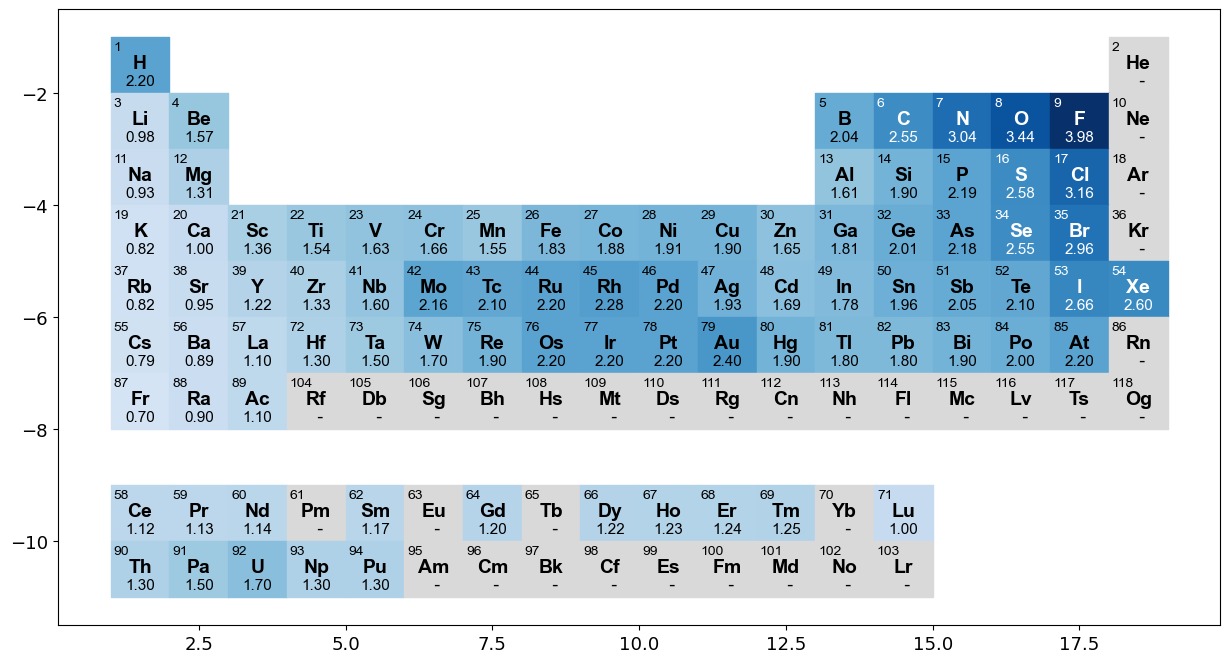

In [138]:
import mendeleev
import matplotlib.pyplot as plt
import matplotlib as mpl
f, ax = plt.subplots(1,1,figsize=(15,8))
cy = 0
#ptable = {}
boxes = []
cmap = mpl.cm.Blues
cmap.set_under([0.85,0.85,0.85])
for i in range(1,119):
    if i not in ptable.keys():
        t = mendeleev.element(i).symbol
        z = mendeleev.element(i).en_pauling
        x = mendeleev.element(i).period
        y = mendeleev.element(i).group_id
        ptable[i] = t, z, x, y
    else:
        t, z, x, y = ptable[i]
    if y == None:
        cy += 1
        y = cy
        x += 3
    else:
        cy = 0       
    if z is None: z = -1
    
    x=-x
#    print(i, x,y)
    ax.fill_between([y, y+1], x, x-1, color=cmap(z/3.98))
    color = [0,0,0]
    if z > 2.5: color = [1,1,1]
    ax.text(y+0.05, x-0.24, str(i), fontsize=10, fontfamily='arial', color=color)
    ax.text(y+0.5, x-0.55,t, fontsize=14, fontweight='bold', fontfamily='arial', color=color, horizontalalignment='center')
    if z < 0:
        ax.text(y+0.5, x-0.85, '-')
    else:
        ax.text(y+0.5, x-0.85, f'{z:.2f}', fontsize=11, fontfamily='arial', color=color, horizontalalignment='center')
f.savefig('./figs/ptable.electronegativity.pdf')


In [81]:
import pickle

TypeError: 'PathCollection' object is not subscriptable